In [1]:
from pygranso.private.getNvar import getNvarTorch
from pygranso.pygranso import pygranso
from pygranso.pygransoStruct import pygransoStruct

import torch
import torch.nn as nn

import time

# Interval is [0.5, 2.5]
%matplotlib widget

In [2]:
from torch.autograd.functional import hessian
import torch
import numpy as np

np.random.seed(10)


def objective(x):
    return torch.sin(10 * torch.pi * x) / (2 * x) + (x - 1) ** 4


# def objective(x):
#     return x**2


def func(W, wr):
    a, b = 0.5, 2.5
    output = X_tensor * torch.prod(W)
    output = a + (b - a) / 2.0 * (torch.sin(output) + 1)
    return objective(output)


# Create a simple dataset
D = 1  # Input dimension
K = 1  # Output dimension
N = 1  # Number of data points
X = np.random.rand(N, D)
y = np.random.rand(N, K)
wr = torch.randn((2, 2), dtype=torch.double)

# Convert data to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.double, requires_grad=False)
y_tensor = torch.tensor(y, dtype=torch.double, requires_grad=False)

# Now let W vary and we can calculate all of these things as we expand the space
resolution = 250
W0_range = np.linspace(-2, 0, resolution)
W1_range = np.linspace(0, 2, resolution)
# W0_range = np.random.randn(100) * 2
# W1_range = np.random.randn(100) * 2
Z = np.zeros((resolution, resolution))
GRAD = np.zeros((resolution, resolution))
HESS_PROD = np.zeros((resolution, resolution))

obj = lambda w: func(w, wr)

for i, W0 in enumerate(W0_range):
    for j, W1 in enumerate(W1_range):
        W = torch.tensor([[W0], [W1]], dtype=torch.double, requires_grad=True)

        # First calculate the gradient
        loss = obj(W)
        Z[i, j] = loss.detach().cpu().numpy().flatten()[0]

        loss.backward()
        gradient = W.grad.view(-1)
        GRAD[i, j] = np.max(gradient.detach().cpu().numpy())

        # Calculate the hessian
        H = hessian(obj, W)
        H = H.reshape(2, 2)
        hessian_np = H.detach().numpy()
        eigenvalues = np.linalg.eigvals(hessian_np)

        # if Z[i, j] < -0.869:
        #     import pdb; pdb.set_trace()

        if np.all(eigenvalues >= 0):
            value = -1
        elif np.all(eigenvalues <= 0):
            value = 0
        elif np.all(eigenvalues == 0):
            value = 1
        # else:
        #     value = 2
        HESS_PROD[i, j] = np.prod(eigenvalues)

In [3]:
isolated_z_minimum = Z.copy()
isolated_z_minimum[isolated_z_minimum > -0.85] = 1.0

In [4]:
Z[Z < -0.85]

array([-0.86723029, -0.85535952, -0.8623462 , -0.86262522, -0.85697531,
       -0.86626157, -0.86858516, -0.86881666, -0.85531694, -0.86746164,
       -0.86226758, -0.86326427, -0.86530661, -0.85939931, -0.8689333 ,
       -0.86897779, -0.86539978, -0.86018586, -0.85792318, -0.86671135,
       -0.85192221, -0.86832261, -0.86596815, -0.858999  , -0.867117  ,
       -0.85756811, -0.86896988, -0.85575876, -0.8675352 , -0.85726246,
       -0.86735597, -0.86796725, -0.85578757, -0.86483055, -0.86162499,
       -0.85799022, -0.86694649, -0.86850168, -0.85232792, -0.86831458,
       -0.85507061, -0.85307819, -0.8686987 , -0.85895904, -0.8667692 ,
       -0.86106496, -0.86588504, -0.86834881, -0.85550291, -0.86610655,
       -0.86054982, -0.85882345, -0.86706072, -0.86858516, -0.85319393,
       -0.8680909 , -0.85703317, -0.85261151, -0.86890116, -0.85756091,
       -0.86772523, -0.8590668 , -0.86746164, -0.86739357, -0.85947084,
       -0.8636118 , -0.86466997, -0.85496761, -0.86851025, -0.86

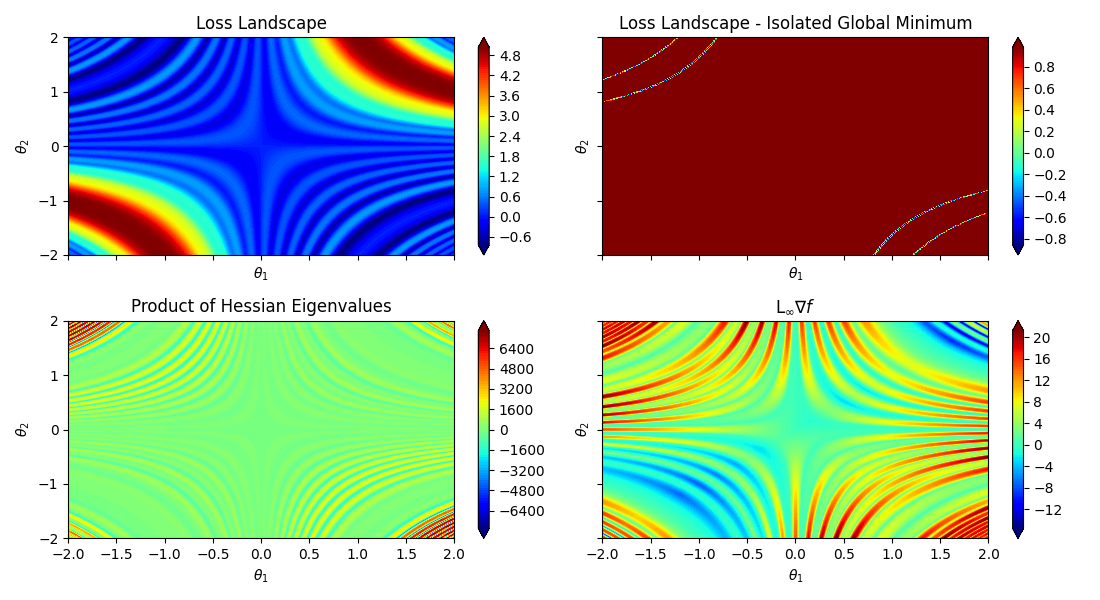

In [9]:
import matplotlib.pyplot as plt

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(11, 6), sharex=True, sharey=True
)

# Plot the weights vs. the loss landscale
c1 = ax1.contourf(W0_range, W1_range, Z, levels=100, cmap='jet', extend='both')
ax1.set_title("Loss Landscape")
ax1.set_xlabel("$ \\theta _1$")
ax1.set_ylabel("$ \\theta _2$")

fig.colorbar(c1, orientation='vertical')

# Plot the weights vs. the isolated minimum values
c2 = ax2.contourf(
    W0_range, W1_range, isolated_z_minimum, levels=100, cmap='jet', extend='both'
)
ax2.set_title("Loss Landscape - Isolated Global Minimum")
ax2.set_xlabel("$ \\theta _1$")
ax2.set_ylabel("$ \\theta _2$")

fig.colorbar(c2, orientation='vertical')

# Plot of max hessian values vs. weights
c3 = ax3.contourf(W0_range, W1_range, HESS_PROD, levels=100, cmap='jet', extend='both')
ax3.set_title("Product of Hessian Eigenvalues")
ax3.set_xlabel("$ \\theta _1$")
ax3.set_ylabel("$ \\theta _2$")

fig.colorbar(c3, orientation='vertical')

# Plot of max gradient value vs. weights
c4 = ax4.contourf(W0_range, W1_range, GRAD, levels=100, cmap='jet', extend='both')
ax4.set_title("L$_{\\infty} \\nabla f$")
ax4.set_xlabel("$ \\theta _1$")
ax4.set_ylabel("$ \\theta _2$")

fig.colorbar(c4, orientation='vertical')

fig.tight_layout()
# fig.savefig('/Users/ryandevera/data-science/umn_environments/Deeplifting/paper-images/loss-landscape.png')

In [10]:
x, y = np.meshgrid(W0_range, W1_range)

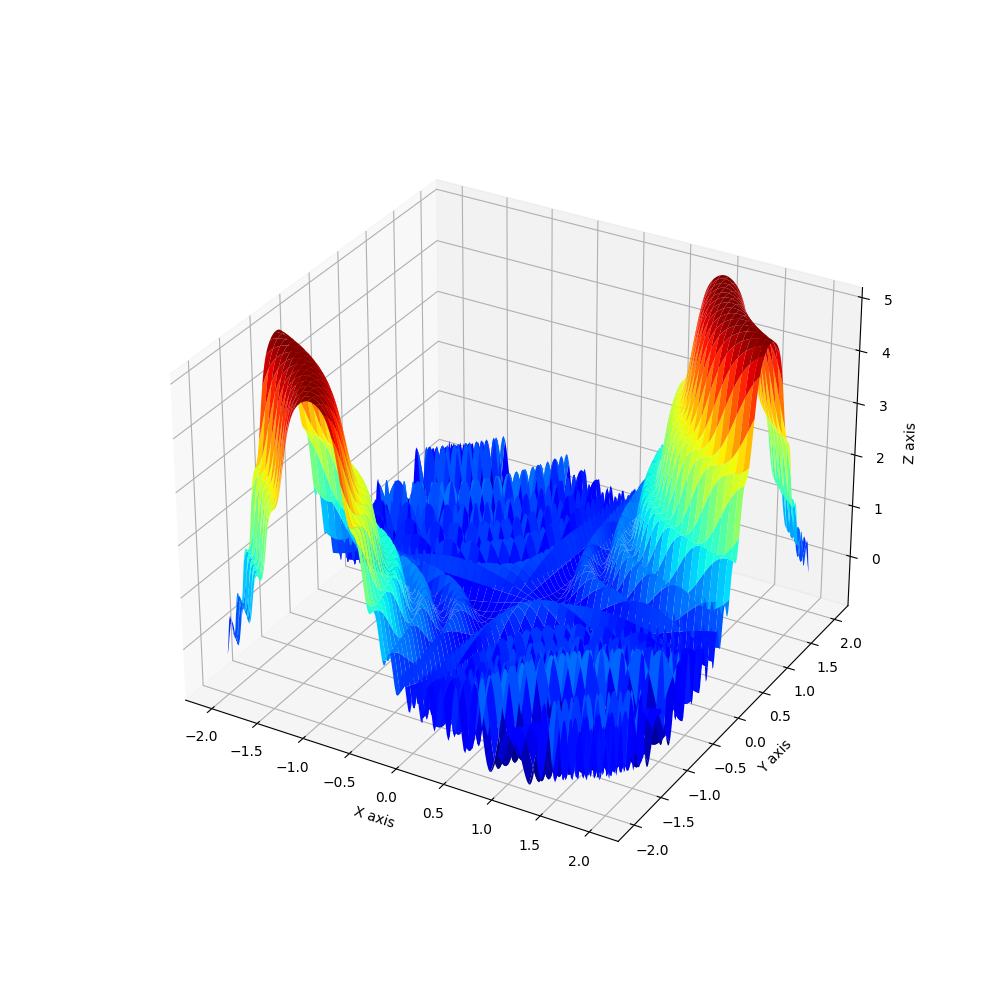

In [8]:
# Set up a figure and a 3D axis
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
ax.plot_surface(x, y, Z, cmap='jet')

# Add labels and title
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

# Show the plot
plt.show()

In [ ]:
minima = [
    -1.0,
    -3.0,
    -6.0,
    -9.103852,
    -12.712062,
    -16.505384,
    -19.821489,
    -24.113360,
    -28.422532,
    -32.765970,
    -37.967600,
    -44.326801,
    -47.845157,
    -52.322627,
    -56.815742,
    -61.317995,
    -66.530949,
    -72.659782,
    -77.1777043,
]

dimensions = 30
k = int(dimensions / 3)
minima[k - 2]